In [1]:
# establish a path for a specific subject 
# this analysis can be performed either on the google drive folder of the project (if you have access) or locally 
# (for which the root and subject_figures_path have to be adapted according to the user's preference)

# try to run the code on google colab...
try:
  from google.colab import drive
  drive.mount('/content/drive/')
  shared_drive_foldername = 'NUTRECON'
  root = '/content/drive/Shareddrives/{}/'.format(shared_drive_foldername)
  subject_figures_path = root + "4. Results/2. Group level/"
  !pip install pandas==1.4.2
  print('Running Code in Colab')
# ...or locally
except:
  # define the local directory of the project
#   root = "C:/Users/DiogoMelo/nutreconDrive/"
  root = 'D:/FV/Projects/NUTRECON/nutreconDrive/'
  # define a path to save the the figures from the analysis
#   subject_figures_path = "C:/Users/DiogoMelo/NUTRECON/Results/Group Level/"
  subject_figures_path = "D:/FV/Projects/NUTRECON/Results/Group Level/"
  print('Running Code locally')

# import necessary packages
import pandas as pd
import numpy as np
from datetime import datetime
from glob import glob
import sys
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
#from sklearn.linear_model import LogisticRegression
from numpy.core.fromnumeric import resize
from pathlib import Path

# append the folder containing the data acquisition Jupyter Notebooks to the system's path
sys.path.append(root + '1. Acquisition/notebooks')
# import nutrecon.py variables and functions
from nutrecon import *

# variable names and IDs object initiation
_v_ = Vars()

experiment_code = _v_.experiment_code
dataPath = _v_.dataPath
# path for the folders containing the sequence and response files, respectively
sequences_dataPath = _v_.sequences_dataPath
responses_dataPath = _v_.responses_dataPath

# correspondance between flavors tested and single letter code
flavorCodes = _v_.flavorCodes

# correspondance between image number and shape
imageCodes = _v_.imageCodes

# map of indexes to image numbers
imageDecoder = _v_.imageDecoder

# set of file identifiers and column names for dataframes

pres_order_fileID = _v_.pres_order_fileID
pres_order_colName = _v_.pres_order_colName
flavorID_colName = _v_.flavorID_colName
flavorName_colName = _v_.flavorName_colName

pres_order_d2_fileID = _v_.pres_order_d2_fileID
pres_order_d3_fileID = _v_.pres_order_d3_fileID

# these files contain the ratings of intensity, novelty and pleasantness for each of the three days
flav_ratings_fileID = _v_.flav_ratings_fileID

intensity_colName = _v_.intensity_colName
novelty_colName = _v_.novelty_colName
pleasanteness_colName = _v_.pleasanteness_colName

# order of the four selected flavors at day 1 learnig phase
learn_order_fileID = _v_.learn_order_fileID
learningOrder_colName = _v_.learningOrder_colName
imageName_colName = _v_.imageName_colName
imageID_colName = _v_.imageID_colName

# order of flavour presentation during day 1 association test
assocTestOrder1_colName = _v_.assocTestOrder1_colName
assoc1_order_fileID = _v_.assoc1_order_fileID

# order of flavour presentation during day 2 association test
assocTestOrder2_colName = _v_.assocTestOrder2_colName
assoc2_order_fileID = _v_.assoc2_order_fileID

# order of flavour presentation during day 3 association test
assocTestOrder3_colName = _v_.assocTestOrder3_colName
assoc3_order_fileID = _v_.assoc3_order_fileID

neuroEconOrder1_fileID = _v_.neuroEconOrder1_fileID
neuroEconOrder2_fileID = _v_.neuroEconOrder2_fileID

conditioning_order_fileID = _v_.conditioning_order_fileID
conditioning_order_colName = _v_.conditioning_order_colName

ratings_id = _v_.ratings_id
orders_id = _v_.orders_id
neuroEcon_id = _v_.neuroEcon_id

subject_code_list = list(set([s.split('\\')[-1].split('_')[0] for s in glob('{}{}*{}*'.format(responses_dataPath, experiment_code, ratings_id))]))


Running Code locally
Running Code locally


## Ratings

In [2]:
# # find the file containing learning order of the flavors at day 1
# learning_path = glob('{}{}*{}*'.format(sequences_dataPath, subject_code, learn_order_fileID))[0]
# learnig_df = pd.read_json(learning_path).T
# learnig_df[flavorName_colName].tolist()
# # find the file containing all the information on the neuroeconomis task realized at day 2
# neuroEcon_id = _v_.neuroEcon_id
# neuroEcon_df = pd.read_json(glob('{}{}*{}*'.format(responses_dataPath, subject_code, neuroEcon_id))[0])
# # search within the neuroeconomics dataframe which flavors are paired/not paired with nutrient (Cplus and Cminus)
# flavor_Cplus = neuroEcon_df[neuroEcon_df['Trial Type'] == 'mixed_yogurt'].iloc[0]['reference flavor']
# flavor_Cminus = neuroEcon_df[neuroEcon_df['Trial Type'] == 'mixed_yogurt'].iloc[0]['lottery flavor']
# marker_order = ['^' if flavor == flavor_Cplus else 'v' if flavor == flavor_Cminus else 'o' if flavor in learning_df[flavorName_colName].tolist() else 'x' for flavor in list(flavorCodes.keys())]

In [3]:
# Load all subject Ratings
for subject_code in subject_code_list:
  # Build subject rating paths from subject code
  ratings_paths = glob('{}{}*{}*'.format(responses_dataPath, subject_code, ratings_id))
  for ratings_path in ratings_paths:
    # Load ratings per day
    dayRating_df = pd.read_json(ratings_path)
    # Get presentation order path
    fpath, day, preOrder, timestamp =  ratings_path.split('_')
    order_path = glob('{}_{}{}*'.format(fpath.replace('responses', 'sequences'), day, orders_id))[0]
    # Load presentation order
    dayOrder_df = pd.read_json(order_path).T
    dayOrder_df['Trial'] = np.arange(len(dayOrder_df)) + 1
    # match presentation order and ratings
    dayRating_df = dayRating_df.merge(dayOrder_df[[flavorName_colName, flavorID_colName, 'Trial']], left_on = 'Trial', right_on = 'Trial') 
    if ratings_path == ratings_paths[0]:
      subjectRatings_df = dayRating_df
    else: 
      subjectRatings_df = pd.concat([subjectRatings_df, dayRating_df])
  # Create different dataframes
  if subject_code == subject_code_list[0]:
    allRatings_df = subjectRatings_df
  else:
    allRatings_df = pd.concat([allRatings_df, subjectRatings_df])


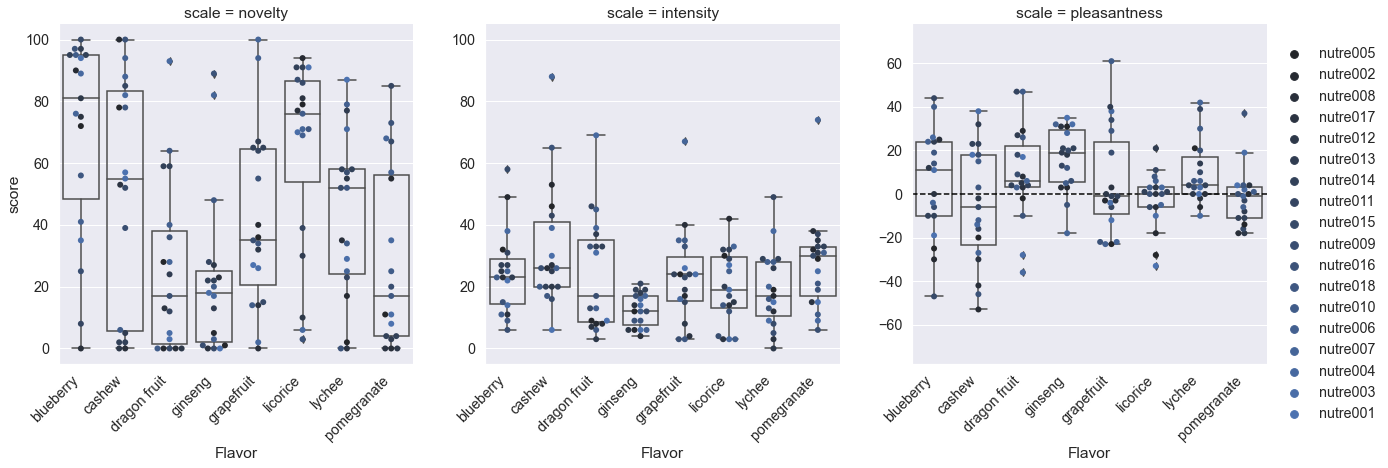

In [4]:
## ---------- PLOT ----------
# all Ratings day 1 plot 

# remove timestamp cols
timestamp_cols = [s for s in allRatings_df.columns if 'timestamp' in s]
day1_ratings_df = allRatings_df[allRatings_df['Day'] == 1].drop(columns=timestamp_cols + ['Day'])

# Remove Top and right spines, set theme and define font scale 
custom_params = {"axes.spines.right": False, "axes.spines.top": False};
sns.set_theme(style="whitegrid", rc=custom_params, palette = 'colorblind');
sns.set(font_scale=1.3);

# melt Dataframe for plot with seaborn
day1_ratings_longdf = day1_ratings_df.melt(id_vars = ['Trial', 'User', flavorName_colName, flavorID_colName], var_name='scale', value_name='score')

# Create Figure Subplots with mapped dataframe
g = sns.FacetGrid(day1_ratings_longdf, col="scale", col_order = [novelty_colName, intensity_colName, pleasanteness_colName], sharey = False, legend_out = True,  height = 6, aspect = 1);
# add swarmplot
g.map_dataframe(sns.swarmplot, x=flavorName_colName, y="score", hue = 'User', order = sorted(day1_ratings_longdf[flavorName_colName].unique()), size=6);
# add boxplot
g.map_dataframe(sns.boxplot, x=flavorName_colName, y="score", order = sorted(day1_ratings_longdf[flavorName_colName].unique()), boxprops=dict(facecolor=(0,0,0,0)));
# change X tick labels
g.set_xticklabels(sorted(day1_ratings_longdf[flavorName_colName].unique()), rotation=45, ha= 'right');
# change Y-axis limits
g.axes[0,0].set_ylim([-5,105]);
g.axes[0,1].set_ylim([-5,105]);
g.axes[0,2].set_ylim([-78,78]);
# add horizontal line to pleasantness graph
g.axes[0,2].axhline(0, ls = '--', c = 'black');

g.add_legend();

In [5]:
# pointplot of Day 1, Day 2 and Day 3 per subject with CS+ and CS-

# Parameter estimation

In [6]:
optimize_cols

NameError: name 'optimize_cols' is not defined

In [7]:
column_names = ['reference type', 'reference qt', 'reference p',
                'lottery type', 'lottery qt', 'lottery p',
                'ref_alpha', 'lott_alpha', 'beta',
                'ref_EU', 'lott_EU', 'pL', 'choice',
                'ref_alphaEstimates', 'lott_alphaEstimates', 'betaEstimates',
                'ref_alphaEstimStdErr', 'lott_alphaEstimStdErr', 'betaEstimStdErr',
                'scal_factor_CplusEstimates', 'scal_factor_CplusEstimStdErr',
                'scal_factor_CminusEstimates', 'scal_factor_CminusEstimStdErr']
optimize_cols = column_names[:6]  + [column_names[12]]

# ======================================================
#         Same-Type Parameters (alpha and beta)
# ======================================================
def get_EU_(p,X, alpha):
  """
  Computes Expected Utility.

  Parameter
  ---------
  p : float
      Reward probability
  X : float
      Reward quantity
  alpha : float
      Risk-aversion parameter

  Returns
  -------
  float
      Expected Utility.
  """
  return p * X**alpha

def get_pL_(euL, euR, beta):
  """
  Computes probability of choosing lottery option.

  Parameter
  ---------
  euL : float
      Expected Utility for lottery option
  euR : float
      Expected Utility for reference option
  beta : float
      Noise parameter

  Returns
  -------
  float
      Probability of choosing lottery option.  
  """
  return 1 - 1/(1 + np.exp(beta * (euL - euR)))


def get_likelihood(row, params, cols = optimize_cols):
  """ 
  Calculates the likelihood of a given choice in one trial.

  Parameter
  ---------
  row : pandas series (row)
      trial information and structure
  params : tupple
      parameter estimates
  cols : list
      list of column names - ['reference type',  'reference qt',
                    'reference p', 'lottery type', 'lottery qt',
                    'lottery p', 'choice']

  Returns
  -------
  float
      Likelihood

  """

  ref_type = row[cols[0]]   # reference reward type (CS+, CS- or money)
  ref_X = row[cols[1]]      # reference reward quantity
  ref_p = row[cols[2]]      # reference reward probability
  lott_type = row[cols[3]]  # lottery reward 
  lott_X = row[cols[4]]     # lottery reward
  lott_p = row[cols[5]]     # lottery reward
  choice = row[cols[6]]     # subject choice

  # map parameter estimates to variables
  if len(params) == 4:
    (alpha_money, alpha_Cplus, alpha_Cminus, beta) = params
    alphas = {'money' : alpha_money,
             'C+' : alpha_Cplus,
             'C-' : alpha_Cminus}
    ref_alpha = alphas[ref_type]
    lott_alpha = alphas[lott_type]
  elif len(params) == 6:
    (alpha_money, alpha_Cplus, alpha_Cminus, beta_money, beta_Cplus, beta_Cminus) = params
    alphas = {'money' : alpha_money,
             'C+' : alpha_Cplus,
             'C-' : alpha_Cminus}
    betas = {'money' : beta_money,
             'C+' : beta_Cplus,
             'C-' : beta_Cminus}
    ref_alpha = alphas[ref_type]
    lott_alpha = alphas[lott_type]
    beta = betas[lott_type]
  
  # compute reference Expected Utility
  ref_EU = get_EU_(ref_p, ref_X, ref_alpha)
  # compute lottery Expected Utility
  lott_EU = get_EU_(lott_p, lott_X, lott_alpha)
  # compute probability of choosing lottery
  pL = get_pL_(lott_EU, ref_EU, beta)

  if choice == 1:
    likelihood = pL
  else:
    likelihood = 1 - pL
  return likelihood

def get_negLogLikelihood(params, args):

  """ 
  Computes begative log-likelihood of parameter estimates. Used with scipy.optimize.minimize.

  Parameters
  ----------
  params : tupple
      parameter estimates
  args : pandas DataFrame
      dataframe with trial information and subject choices

  Returns
  -------
  float
      Negative log-likelihood
  """

  df = args
  task_cols = optimize_cols
  # compute likelihood of each choice
  likelihood = df.apply(lambda row: get_likelihood(row, params, task_cols), axis=1).values
  # Take negative of logLikelihood for convention
  negloglikelihood = - np.sum(np.log(likelihood))
  return negloglikelihood

# ==============================================
#     Mixed-Type Parameters (alpha and beta)
# ==============================================

# compute expected utility
def get_mixed_EU_(p,X, reward_type, parsCI):
  # This value is obtained by multiplying the probability of recieving a specific reward associated with a choice by the real value of the reward. Furthermore, the real value is raised to the power of an alpha parameter
  # which represents the subject-by-subject level of risk aversion for a specific reward type. If alpha > 1, the indiviudal is considered a risk seaker and if alpha < 1, the individual is considered risk averse.
  if reward_type == 'money':
    alpha = float(parsCI[0].split(' ')[0])
  elif reward_type == 'C+':
    alpha = float(parsCI[1].split(' ')[0])
  elif reward_type == 'C-':
    alpha = float(parsCI[2].split(' ')[0])
  return p * X**alpha

# Probability of chosing lottery given the expected utility of both choices (logistic function)
# In this case, I am taking into account mixed type trials in which the reference option is money and the lottery option is C+ or C-
# Note that multiplying by a scaling factor nests the same type trials, in which the scaling factor is 1
def get_mixed_pL_(euL, euR, scaling_factor, parsCI):
  # get beta value estimated for same type trials
  beta = float(parsCI[3].split(' ')[0])
  return 1 - 1/(1 + np.exp(beta * (euL * scaling_factor - euR)))

# this function nests get_mixed_pL_ to compute the likelihood of the evidence (choices) given the hypothesis (internal parameters of the model)
# observational model (the function I want to maximize; I want to see "where" is the maximum of this function, which is to say, I want to find the internal model parameters for which this function peaks...
# ...OR, which are the parameters that better explain my evidence (in this case, observed behavior in the form of trial by trial choices)) 

# Added parsCI = parsCI as input. parsCI contains the alphas necessary for computing expected utilities
def get_mixed_likelihood(row, params, cols, parsCI):
  # search for the reward type of the reference option
  ref_type = row[cols[0]]
  # search for the reward type of the lottery option
  lott_type = row[cols[3]]

  # not sure if this should include beta
  (scaling_factor_Cplus, scaling_factor_Cminus) = params # parameters I want to estimate
  
  scaling_factors = {'C+' : scaling_factor_Cplus,
                      'C-' : scaling_factor_Cminus}

  choice = row[cols[6]]

  ref_X = row[cols[1]]
  ref_p = row[cols[2]]
  # Switched the ref_alpha for [ref_type, parsCI] that allow me to get the alpha values for the same type trials
  ref_EU = get_mixed_EU_(ref_p, ref_X, ref_type, parsCI)
  
  lott_X = row[cols[4]]
  lott_p = row[cols[5]]
  # Switched the lott_alpha for [lott_type, parsCI] that allow me to get the alpha values fo rthe same type trials
  lott_EU = get_mixed_EU_(lott_p, lott_X, lott_type, parsCI)

  # Added scaling_factor which is now necessary for computing likelihood
  pL = get_mixed_pL_(lott_EU, ref_EU, scaling_factors[lott_type], parsCI)
  # 0 - chosing the reference option; 1 - chosing the lottery option; 2 - missed trial (need to confirm with Francisco)
  if choice == 1:
    likelihood = pL
  else:
    likelihood = 1 - pL
  return likelihood

# working with the log of the likelihood instead of the likelihood directly is numerically more stable
# if you print negloglikelihood and run the following cell, you will notice that the likelihood distribution of the parameters is not continuous in the whole space (goes to infinite for some parameter combinations)
def get_mixed_negLogLikelihood(params, args):
  df = args[0]
  parsCI = args[1] 
  task_cols = optimize_cols
  # compute likelihood of each choice and saves likelihoods in 
  likelihood = df.apply(lambda row: get_mixed_likelihood(row, params, task_cols, parsCI), axis=1).values
  # Take negative of logLikelihood for convention
  negloglikelihood = - np.sum(np.log(likelihood))
  return negloglikelihood

sub_dic = {}
def estimate_Subejct_parameters(grouped_df):

  parameter_cols = ['alpha CS+ day2', 
                    'alpha CS- day2', 
                    'alpha Money day2',
                    'beta day2',
                    'scalingFactor CS+ day2',
                    'scalingFactor CS- day2',
                    'alpha CS+ day3', 
                    'alpha CS- day3', 
                    'alpha Money day3',
                    'beta day3',
                    'scalingFactor CS+ day3',
                    'scalingFactor CS- day3',]

  # ==========================================
  #                   Day 2
  # ==========================================
  # __________________________________________
  # Same-Type
  
  alphaMoney0 = 0
  alphaCplus0 = 0
  alphaCminus0 = 0
  beta0 = 0

  df_day2 = grouped_df[grouped_df['Day'] == 2]

  df_sameType = df_day2[df_day2['Trial Type'] == 'same']
  df_sameType['choice'] = np.where(df_sameType['choice'] == 2, 1, 0)

  args = (df_sameType)
  x0 = (alphaMoney0, alphaCplus0, alphaCminus0, beta0)
  res = minimize(get_negLogLikelihood, x0, args=args )

  parsCI_d2 = ['{} \xb1 {}'.format(round(res.x[p],3), round(1.96*np.sqrt(np.diag(res.hess_inv))[p],3)) for p in range(len(res.x))]

  alpha_money_d2 = parsCI_d2[0]
  alpha_cPlus_d2 = parsCI_d2[1]
  alpha_cMinus_d2 = parsCI_d2[2]

  # __________________________________________
  # Mixed-Type

  # parsCI = parsCI_d2

  # define starting values for the internal parameters of the model
  scaling_factor_Cplus_d2 = 1
  scaling_factor_Cminus_d2 = 1

  # create a new dataframe containing only the mixed type trials from day 2 neuroecon task
  df_mixedType_d2 = df_day2[df_day2['Trial Type'] == 'mixed']

  df_mixedType_d2['choice'] = np.where(df_mixedType_d2['choice'] == 2, 1, 0)

  args_d2_MT = (df_mixedType_d2)

  # starting guess
  x0_d2_MT = (scaling_factor_Cplus_d2, scaling_factor_Cminus_d2)
  # in order to obtain to most likely parameters, we take the negative of the log likelihood function and minimize it
  res_d2_MT = minimize(get_mixed_negLogLikelihood, x0_d2_MT, args=[args_d2_MT, parsCI_d2]) # options={'maxiter' : 100})

  # hessian - variance and covariance (how peaked is the function maximum); inverse hessian - how spread is the log likelihood function around the maximum
  # the reverse hessian (matrix containing the second derivative of the likelihood function with respect to the internal model parameters) can be use to compute confidence intervals
  parsCI_d2_MT = ['{} \xb1 {}'.format(round(res_d2_MT.x[p],3), round(1.96*np.sqrt(np.diag(res_d2_MT.hess_inv))[p],3)) for p in range(len(res_d2_MT.x))]

  # ==========================================
  #                   Day 3
  # ==========================================
  alphaMoney0 = 0
  alphaCplus0 = 0
  alphaCminus0 = 0
  beta0 = 0

  df_day3 = grouped_df[grouped_df['Day'] == 3]

  if len(df_day3) > 0:
    # __________________________________________
    # Same-Type
    df_sameType = df_day3[df_day3['Trial Type'] == 'same']
    df_sameType['choice'] = np.where(df_sameType['choice'] == 2, 1, 0)
    
    args = (df_sameType)
    x0 = (alphaMoney0, alphaCplus0, alphaCminus0, beta0)
    res = minimize(get_negLogLikelihood, x0, args=args )

    parsCI_d3 = ['{} \xb1 {}'.format(round(res.x[p],3), round(1.96*np.sqrt(np.diag(res.hess_inv))[p],3)) for p in range(len(res.x))]

    alpha_money_d3 = parsCI_d3[0]
    alpha_cPlus_d3 = parsCI_d3[1]
    alpha_cMinus_d3 = parsCI_d3[2]

    # __________________________________________
    # Mixed-Type
    scaling_factor_Cplus_d3 = 1
    scaling_factor_Cminus_d3 = 1
    df_mixedType_d3 = df_day3[df_day3['Trial Type'] == 'mixed']
  
    df_mixedType_d3['choice'] = np.where(df_mixedType_d3['choice'] == 2, 1, 0)
    
    args_d3_MT = (df_mixedType_d3)
    x0_d3_MT = (scaling_factor_Cplus_d3, scaling_factor_Cminus_d3)
    res_d3_MT = minimize(get_mixed_negLogLikelihood, x0_d3_MT, args=[args_d3_MT, parsCI_d3])
    
    parsCI_d3_MT = ['{} \xb1 {}'.format(round(res_d3_MT.x[p],3), round(1.96*np.sqrt(np.diag(res_d3_MT.hess_inv))[p],3)) for p in range(len(res_d3_MT.x))]

    print('\nDay 2 parameters:')
    print('  - {}: {}'.format('alpha Money', parsCI_d2[0]))
    print('  - {}: {}'.format('alpha C+', parsCI_d2[1]))
    print('  - {}: {}'.format('alpha C-', parsCI_d2[2]))
    print('  - {}: {}'.format('beta', parsCI_d2[3]))
    print('  - {}: {}'.format('scaling_factor C+', parsCI_d2_MT[0]))
    print('  - {}: {}'.format('scaling factor C-', parsCI_d2_MT[1]))

    print('\nDay 3 parameters:')
    print('  - {}: {}'.format('alpha Money', parsCI_d3[0]))
    print('  - {}: {}'.format('alpha C+', parsCI_d3[1]))
    print('  - {}: {}'.format('alpha C-', parsCI_d3[2]))
    print('  - {}: {}'.format('beta', parsCI_d3[3]))
    print('  - {}: {}'.format('scaling_factor C+', parsCI_d3_MT[0]))
    print('  - {}: {}'.format('scaling factor C-', parsCI_d3_MT[1]))
    dic = {}
    dic[parameter_cols[0]] = parsCI_d2[1]
    dic[parameter_cols[1]] = parsCI_d2[2]
    dic[parameter_cols[2]] = parsCI_d2[0]
    dic[parameter_cols[3]] = parsCI_d2[3]
    dic[parameter_cols[4]] = parsCI_d2_MT[0]
    dic[parameter_cols[5]] = parsCI_d2_MT[1]
    dic[parameter_cols[6]] = parsCI_d3[1]
    dic[parameter_cols[7]] = parsCI_d3[2]
    dic[parameter_cols[8]] = parsCI_d3[0]
    dic[parameter_cols[9]] = parsCI_d3[3]
    dic[parameter_cols[10]] = parsCI_d3_MT[0]
    dic[parameter_cols[11]] = parsCI_d3_MT[1]
  else:
    print('\nDay 2 parameters:')
    print('  - {}: {}'.format('alpha Money', parsCI_d2[0]))
    print('  - {}: {}'.format('alpha C+', parsCI_d2[1]))
    print('  - {}: {}'.format('alpha C-', parsCI_d2[2]))
    print('  - {}: {}'.format('beta', parsCI_d2[3]))
    print('  - {}: {}'.format('scaling_factor C+', parsCI_d2_MT[0]))
    print('  - {}: {}'.format('scaling factor C-', parsCI_d2_MT[1]))
    print('\nDay 3 responses not loaded')
    dic = {}
    dic[parameter_cols[0]] = parsCI_d2[1]
    dic[parameter_cols[1]] = parsCI_d2[2]
    dic[parameter_cols[2]] = parsCI_d2[0]
    dic[parameter_cols[3]] = parsCI_d2[3]
    dic[parameter_cols[4]] = parsCI_d2_MT[0]
    dic[parameter_cols[5]] = parsCI_d2_MT[1]
    dic[parameter_cols[6]] = ''
    dic[parameter_cols[7]] = ''
    dic[parameter_cols[8]] = ''
    dic[parameter_cols[9]] = ''
    dic[parameter_cols[10]] = ''
    dic[parameter_cols[11]] = ''
  
  sub_dic[grouped_df['User'].unique()[0]] = dic
 


In [8]:
# load all neuroeconomics responses
for subject_code in subject_code_list:
  neuroEcon_paths = glob('{}{}*{}*'.format(responses_dataPath, subject_code, neuroEcon_id))
  for neuroEcon_path in neuroEcon_paths:
    dayNeuroEcon_df = pd.read_json(neuroEcon_path)
    if neuroEcon_path == neuroEcon_paths[0]:
      sub_neuroEcon_df = dayNeuroEcon_df
    else:
      if subject_code == 'nutre007':
        dayNeuroEcon_df['Day'] = 'day3'
      sub_neuroEcon_df = pd.concat([sub_neuroEcon_df, dayNeuroEcon_df])
  if subject_code == subject_code_list[0]:
    all_neuroEcon_df = sub_neuroEcon_df
  else:
    all_neuroEcon_df = pd.concat([all_neuroEcon_df, sub_neuroEcon_df])

all_neuroEcon_df.reset_index(inplace= True, drop=True)
all_neuroEcon_df['reaction_time'] = all_neuroEcon_df['choiceTime_ms'] - all_neuroEcon_df['choiceStart_ms']
all_neuroEcon_df['Day'] = all_neuroEcon_df['Day'].apply(lambda day: int(day[-1]))

all_neuroEcon_df.head()

,Day,Trial,Trial ID,Trial Type,User,block,choice,choiceStart_ms,choiceTime,choiceTime_ms,...,lottery type,optionTime,reference flavor,reference p,reference qt,reference shape,reference type,trialStartTimestamp,trialStart_ms,reaction_time
0,2,1,99,mixed,nutre005,0,2,32697,2250,33081,...,C+,2000,,1.0,0.2,,money,1672998798,30817,384
1,2,2,117,mixed,nutre005,0,1,35834,2250,36267,...,C-,2000,,1.0,0.2,,money,1672998801,33912,433
2,2,3,122,mixed,nutre005,0,1,39020,2250,39755,...,C-,2000,,1.0,0.2,,money,1672998805,37065,735
3,2,4,84,mixed,nutre005,0,2,42491,2250,43008,...,C+,2000,,1.0,0.2,,money,1672998808,40562,517
4,2,5,112,mixed,nutre005,0,1,45744,2250,46362,...,C-,2000,,1.0,0.2,,money,1672998811,43815,618


In [9]:
all_parameters = all_neuroEcon_df.groupby('User').apply(lambda group_df: estimate_Subejct_parameters(group_df))

C:\Users\Admin\AppData\Local\Temp\ipykernel_10848\1064040328.py:141: RuntimeWarning: divide by zero encountered in log
  negloglikelihood = - np.sum(np.log(likelihood))
C:\Users\Admin\AppData\Local\Temp\ipykernel_10848\1064040328.py:141: RuntimeWarning: divide by zero encountered in log
  negloglikelihood = - np.sum(np.log(likelihood))
c:\Users\Admin\anaconda3\envs\nutrecon\lib\site-packages\scipy\optimize\_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\Admin\AppData\Local\Temp\ipykernel_10848\1064040328.py:141: RuntimeWarning: divide by zero encountered in log
  negloglikelihood = - np.sum(np.log(likelihood))
c:\Users\Admin\anaconda3\envs\nutrecon\lib\site-packages\scipy\optimize\_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\Admin\AppData\Local\Temp\ipykernel_10848\1064040328.py:141: RuntimeWarning: divide by zero encountered in log
  negloglikelihood = - np.sum(np.log(likelihood))



Day 2 parameters:
  - alpha Money: 0.474 ± 0.062
  - alpha C+: 0.374 ± 0.044
  - alpha C-: -0.66 ± 0.31
  - beta: 2.02 ± 0.369
  - scaling_factor C+: 0.515 ± 0.078
  - scaling factor C-: -103.919 ± 24.323

Day 3 parameters:
  - alpha Money: 0.783 ± 0.159
  - alpha C+: 0.728 ± 0.068
  - alpha C-: -0.678 ± 1.382
  - beta: 0.74 ± 0.286
  - scaling_factor C+: 0.307 ± 0.076
  - scaling factor C-: -493.424 ± 376.595


C:\Users\Admin\AppData\Local\Temp\ipykernel_10848\1064040328.py:141: RuntimeWarning: divide by zero encountered in log
  negloglikelihood = - np.sum(np.log(likelihood))
C:\Users\Admin\AppData\Local\Temp\ipykernel_10848\1064040328.py:141: RuntimeWarning: divide by zero encountered in log
  negloglikelihood = - np.sum(np.log(likelihood))
c:\Users\Admin\anaconda3\envs\nutrecon\lib\site-packages\scipy\optimize\_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\Admin\AppData\Local\Temp\ipykernel_10848\1064040328.py:141: RuntimeWarning: divide by zero encountered in log
  negloglikelihood = - np.sum(np.log(likelihood))
c:\Users\Admin\anaconda3\envs\nutrecon\lib\site-packages\scipy\optimize\_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\Admin\AppData\Local\Temp\ipykernel_10848\1064040328.py:141: RuntimeWarning: divide by zero encountered in log
  negloglikelihood = - np.sum(np.log(likelihood))



Day 2 parameters:
  - alpha Money: 0.626 ± 0.066
  - alpha C+: 0.317 ± 0.049
  - alpha C-: 0.057 ± 0.08
  - beta: 4.345 ± 0.861
  - scaling_factor C+: 0.175 ± 0.04
  - scaling factor C-: -26.766 ± 5094.714

Day 3 parameters:
  - alpha Money: 0.329 ± 0.049
  - alpha C+: 0.037 ± 0.131
  - alpha C-: 0.335 ± 0.039
  - beta: 5.292 ± 1.1
  - scaling_factor C+: -6.957 ± 0.481
  - scaling factor C-: 0.233 ± 0.034


C:\Users\Admin\AppData\Local\Temp\ipykernel_10848\1064040328.py:52: RuntimeWarning: overflow encountered in exp
  return 1 - 1/(1 + np.exp(beta * (euL - euR)))
C:\Users\Admin\AppData\Local\Temp\ipykernel_10848\1064040328.py:141: RuntimeWarning: divide by zero encountered in log
  negloglikelihood = - np.sum(np.log(likelihood))
C:\Users\Admin\AppData\Local\Temp\ipykernel_10848\1064040328.py:52: RuntimeWarning: overflow encountered in exp
  return 1 - 1/(1 + np.exp(beta * (euL - euR)))
C:\Users\Admin\AppData\Local\Temp\ipykernel_10848\1064040328.py:141: RuntimeWarning: divide by zero encountered in log
  negloglikelihood = - np.sum(np.log(likelihood))
c:\Users\Admin\anaconda3\envs\nutrecon\lib\site-packages\scipy\optimize\_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\Admin\AppData\Local\Temp\ipykernel_10848\1064040328.py:52: RuntimeWarning: overflow encountered in exp
  return 1 - 1/(1 + np.exp(beta * (euL - euR)))
C:\Users\Admin\AppDa


Day 2 parameters:
  - alpha Money: 1.297 ± 0.198
  - alpha C+: 0.818 ± 0.086
  - alpha C-: 0.882 ± 0.082
  - beta: 0.286 ± 0.103
  - scaling_factor C+: 0.284 ± 0.091
  - scaling factor C-: 0.201 ± 0.066

Day 3 parameters:
  - alpha Money: 1.426 ± 0.226
  - alpha C+: 0.87 ± 0.086
  - alpha C-: 0.894 ± 0.082
  - beta: 0.275 ± 0.099
  - scaling_factor C+: 0.194 ± 0.066
  - scaling factor C-: 0.15 ± 0.054


C:\Users\Admin\AppData\Local\Temp\ipykernel_10848\1064040328.py:52: RuntimeWarning: overflow encountered in exp
  return 1 - 1/(1 + np.exp(beta * (euL - euR)))
C:\Users\Admin\AppData\Local\Temp\ipykernel_10848\1064040328.py:141: RuntimeWarning: divide by zero encountered in log
  negloglikelihood = - np.sum(np.log(likelihood))
C:\Users\Admin\AppData\Local\Temp\ipykernel_10848\1064040328.py:52: RuntimeWarning: overflow encountered in exp
  return 1 - 1/(1 + np.exp(beta * (euL - euR)))
C:\Users\Admin\AppData\Local\Temp\ipykernel_10848\1064040328.py:141: RuntimeWarning: divide by zero encountered in log
  negloglikelihood = - np.sum(np.log(likelihood))
c:\Users\Admin\anaconda3\envs\nutrecon\lib\site-packages\scipy\optimize\_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\Admin\AppData\Local\Temp\ipykernel_10848\1064040328.py:52: RuntimeWarning: overflow encountered in exp
  return 1 - 1/(1 + np.exp(beta * (euL - euR)))
C:\Users\Admin\AppDa


Day 2 parameters:
  - alpha Money: 1.398 ± 0.239
  - alpha C+: 0.86 ± 0.055
  - alpha C-: 0.807 ± 0.063
  - beta: 0.72 ± 0.215
  - scaling_factor C+: 0.495 ± 0.207
  - scaling factor C-: 0.34 ± 0.111

Day 3 parameters:
  - alpha Money: 1.589 ± 0.308
  - alpha C+: 0.81 ± 0.063
  - alpha C-: 0.878 ± 0.051
  - beta: 0.678 ± 0.209
  - scaling_factor C+: 0.461 ± 0.163
  - scaling factor C-: 0.187 ± 0.059


C:\Users\Admin\AppData\Local\Temp\ipykernel_10848\1064040328.py:52: RuntimeWarning: overflow encountered in exp
  return 1 - 1/(1 + np.exp(beta * (euL - euR)))
C:\Users\Admin\AppData\Local\Temp\ipykernel_10848\1064040328.py:141: RuntimeWarning: divide by zero encountered in log
  negloglikelihood = - np.sum(np.log(likelihood))
C:\Users\Admin\AppData\Local\Temp\ipykernel_10848\1064040328.py:52: RuntimeWarning: overflow encountered in exp
  return 1 - 1/(1 + np.exp(beta * (euL - euR)))
C:\Users\Admin\AppData\Local\Temp\ipykernel_10848\1064040328.py:141: RuntimeWarning: divide by zero encountered in log
  negloglikelihood = - np.sum(np.log(likelihood))
c:\Users\Admin\anaconda3\envs\nutrecon\lib\site-packages\scipy\optimize\_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\Admin\AppData\Local\Temp\ipykernel_10848\1064040328.py:52: RuntimeWarning: overflow encountered in exp
  return 1 - 1/(1 + np.exp(beta * (euL - euR)))
C:\Users\Admin\AppDa


Day 2 parameters:
  - alpha Money: 0.412 ± 0.069
  - alpha C+: 0.434 ± 0.064
  - alpha C-: 0.444 ± 0.043
  - beta: 3.153 ± 0.384
  - scaling_factor C+: 0.066 ± 0.03
  - scaling factor C-: 0.125 ± 0.029

Day 3 parameters:
  - alpha Money: 0.328 ± 0.059
  - alpha C+: 0.308 ± 0.05
  - alpha C-: 0.364 ± 0.043
  - beta: 4.218 ± 0.874
  - scaling_factor C+: 0.06 ± 0.056
  - scaling factor C-: 0.16 ± 0.033

Day 2 parameters:
  - alpha Money: -1.052 ± 1.114
  - alpha C+: -0.252 ± 0.229
  - alpha C-: -0.411 ± 0.37
  - beta: -0.978 ± 0.376
  - scaling_factor C+: 19.834 ± 2.906
  - scaling factor C-: 36.352 ± 6.508

Day 3 parameters:
  - alpha Money: -1.305 ± 1.67
  - alpha C+: -0.59 ± 0.68
  - alpha C-: -0.464 ± 0.484
  - beta: -0.744 ± 0.387
  - scaling_factor C+: 121.767 ± 19.824
  - scaling factor C-: 81.343 ± 10.715


C:\Users\Admin\AppData\Local\Temp\ipykernel_10848\1064040328.py:141: RuntimeWarning: divide by zero encountered in log
  negloglikelihood = - np.sum(np.log(likelihood))
C:\Users\Admin\AppData\Local\Temp\ipykernel_10848\1064040328.py:141: RuntimeWarning: divide by zero encountered in log
  negloglikelihood = - np.sum(np.log(likelihood))
c:\Users\Admin\anaconda3\envs\nutrecon\lib\site-packages\scipy\optimize\_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\Admin\AppData\Local\Temp\ipykernel_10848\1064040328.py:141: RuntimeWarning: divide by zero encountered in log
  negloglikelihood = - np.sum(np.log(likelihood))
c:\Users\Admin\anaconda3\envs\nutrecon\lib\site-packages\scipy\optimize\_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\Admin\AppData\Local\Temp\ipykernel_10848\1064040328.py:141: RuntimeWarning: divide by zero encountered in log
  negloglikelihood = - np.sum(np.log(likelihood))



Day 2 parameters:
  - alpha Money: 1.758 ± 0.327
  - alpha C+: 0.957 ± 0.112
  - alpha C-: 0.912 ± 0.109
  - beta: 0.152 ± 0.078
  - scaling_factor C+: 0.251 ± 0.084
  - scaling factor C-: 0.29 ± 0.102

Day 3 parameters:
  - alpha Money: 0.46 ± 64.183
  - alpha C+: 0.395 ± 52.94
  - alpha C-: 0.381 ± 51.101
  - beta: 1.057 ± 140.845
  - scaling_factor C+: 0.412 ± 0.125
  - scaling factor C-: 0.444 ± 0.135


C:\Users\Admin\AppData\Local\Temp\ipykernel_10848\1064040328.py:52: RuntimeWarning: overflow encountered in exp
  return 1 - 1/(1 + np.exp(beta * (euL - euR)))
C:\Users\Admin\AppData\Local\Temp\ipykernel_10848\1064040328.py:141: RuntimeWarning: divide by zero encountered in log
  negloglikelihood = - np.sum(np.log(likelihood))
C:\Users\Admin\AppData\Local\Temp\ipykernel_10848\1064040328.py:52: RuntimeWarning: overflow encountered in exp
  return 1 - 1/(1 + np.exp(beta * (euL - euR)))
C:\Users\Admin\AppData\Local\Temp\ipykernel_10848\1064040328.py:141: RuntimeWarning: divide by zero encountered in log
  negloglikelihood = - np.sum(np.log(likelihood))
c:\Users\Admin\anaconda3\envs\nutrecon\lib\site-packages\scipy\optimize\_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\Admin\AppData\Local\Temp\ipykernel_10848\1064040328.py:52: RuntimeWarning: overflow encountered in exp
  return 1 - 1/(1 + np.exp(beta * (euL - euR)))
C:\Users\Admin\AppDa


Day 2 parameters:
  - alpha Money: 0.516 ± 0.109
  - alpha C+: 0.647 ± 0.051
  - alpha C-: 0.624 ± 0.054
  - beta: 1.294 ± 0.329
  - scaling_factor C+: 0.175 ± 0.044
  - scaling factor C-: 0.212 ± 0.054

Day 3 parameters:
  - alpha Money: 0.372 ± 0.085
  - alpha C+: 0.547 ± 0.048
  - alpha C-: 0.531 ± 0.05
  - beta: 2.019 ± 0.475
  - scaling_factor C+: 0.152 ± 0.03
  - scaling factor C-: 0.163 ± 0.038


C:\Users\Admin\AppData\Local\Temp\ipykernel_10848\1064040328.py:52: RuntimeWarning: overflow encountered in exp
  return 1 - 1/(1 + np.exp(beta * (euL - euR)))
C:\Users\Admin\AppData\Local\Temp\ipykernel_10848\1064040328.py:141: RuntimeWarning: divide by zero encountered in log
  negloglikelihood = - np.sum(np.log(likelihood))
C:\Users\Admin\AppData\Local\Temp\ipykernel_10848\1064040328.py:52: RuntimeWarning: overflow encountered in exp
  return 1 - 1/(1 + np.exp(beta * (euL - euR)))
C:\Users\Admin\AppData\Local\Temp\ipykernel_10848\1064040328.py:141: RuntimeWarning: divide by zero encountered in log
  negloglikelihood = - np.sum(np.log(likelihood))
c:\Users\Admin\anaconda3\envs\nutrecon\lib\site-packages\scipy\optimize\_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\Admin\AppData\Local\Temp\ipykernel_10848\1064040328.py:52: RuntimeWarning: overflow encountered in exp
  return 1 - 1/(1 + np.exp(beta * (euL - euR)))
C:\Users\Admin\AppDa


Day 2 parameters:
  - alpha Money: 0.359 ± 0.047
  - alpha C+: 0.364 ± 0.037
  - alpha C-: 0.354 ± 0.038
  - beta: 5.652 ± 1.271
  - scaling_factor C+: 0.157 ± 0.025
  - scaling factor C-: 0.186 ± 0.027

Day 3 parameters:
  - alpha Money: 0.384 ± 0.048
  - alpha C+: 0.406 ± 0.027
  - alpha C-: 0.353 ± 0.037
  - beta: 5.94 ± 1.459
  - scaling_factor C+: 0.154 ± 0.021
  - scaling factor C-: 0.183 ± 0.026


C:\Users\Admin\AppData\Local\Temp\ipykernel_10848\1064040328.py:52: RuntimeWarning: overflow encountered in exp
  return 1 - 1/(1 + np.exp(beta * (euL - euR)))
C:\Users\Admin\AppData\Local\Temp\ipykernel_10848\1064040328.py:141: RuntimeWarning: divide by zero encountered in log
  negloglikelihood = - np.sum(np.log(likelihood))
C:\Users\Admin\AppData\Local\Temp\ipykernel_10848\1064040328.py:52: RuntimeWarning: overflow encountered in exp
  return 1 - 1/(1 + np.exp(beta * (euL - euR)))
C:\Users\Admin\AppData\Local\Temp\ipykernel_10848\1064040328.py:141: RuntimeWarning: divide by zero encountered in log
  negloglikelihood = - np.sum(np.log(likelihood))
c:\Users\Admin\anaconda3\envs\nutrecon\lib\site-packages\scipy\optimize\_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\Admin\AppData\Local\Temp\ipykernel_10848\1064040328.py:52: RuntimeWarning: overflow encountered in exp
  return 1 - 1/(1 + np.exp(beta * (euL - euR)))
C:\Users\Admin\AppDa


Day 2 parameters:
  - alpha Money: 0.356 ± 0.067
  - alpha C+: 0.432 ± 0.04
  - alpha C-: 0.428 ± 0.041
  - beta: 3.046 ± 0.648
  - scaling_factor C+: 0.18 ± 0.036
  - scaling factor C-: 0.186 ± 0.037

Day 3 parameters:
  - alpha Money: 0.462 ± 0.073
  - alpha C+: 0.442 ± 0.04
  - alpha C-: 0.446 ± 0.039
  - beta: 2.758 ± 0.605
  - scaling_factor C+: 0.162 ± 0.054
  - scaling factor C-: 0.15 ± 0.027


C:\Users\Admin\AppData\Local\Temp\ipykernel_10848\1064040328.py:52: RuntimeWarning: overflow encountered in exp
  return 1 - 1/(1 + np.exp(beta * (euL - euR)))
C:\Users\Admin\AppData\Local\Temp\ipykernel_10848\1064040328.py:141: RuntimeWarning: divide by zero encountered in log
  negloglikelihood = - np.sum(np.log(likelihood))
C:\Users\Admin\AppData\Local\Temp\ipykernel_10848\1064040328.py:52: RuntimeWarning: overflow encountered in exp
  return 1 - 1/(1 + np.exp(beta * (euL - euR)))
C:\Users\Admin\AppData\Local\Temp\ipykernel_10848\1064040328.py:141: RuntimeWarning: divide by zero encountered in log
  negloglikelihood = - np.sum(np.log(likelihood))
c:\Users\Admin\anaconda3\envs\nutrecon\lib\site-packages\scipy\optimize\_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\Admin\AppData\Local\Temp\ipykernel_10848\1064040328.py:52: RuntimeWarning: overflow encountered in exp
  return 1 - 1/(1 + np.exp(beta * (euL - euR)))
C:\Users\Admin\AppDa


Day 2 parameters:
  - alpha Money: 0.37 ± 0.08
  - alpha C+: 0.429 ± 0.047
  - alpha C-: 0.459 ± 0.046
  - beta: 2.285 ± 0.504
  - scaling_factor C+: 0.206 ± 0.048
  - scaling factor C-: 0.183 ± 0.042

Day 3 parameters:
  - alpha Money: 0.341 ± 0.098
  - alpha C+: 0.437 ± 0.046
  - alpha C-: 0.403 ± 0.047
  - beta: 2.529 ± 0.612
  - scaling_factor C+: 0.185 ± 0.041
  - scaling factor C-: 0.222 ± 0.049


C:\Users\Admin\AppData\Local\Temp\ipykernel_10848\1064040328.py:141: RuntimeWarning: divide by zero encountered in log
  negloglikelihood = - np.sum(np.log(likelihood))
C:\Users\Admin\AppData\Local\Temp\ipykernel_10848\1064040328.py:141: RuntimeWarning: divide by zero encountered in log
  negloglikelihood = - np.sum(np.log(likelihood))
c:\Users\Admin\anaconda3\envs\nutrecon\lib\site-packages\scipy\optimize\_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\Admin\AppData\Local\Temp\ipykernel_10848\1064040328.py:141: RuntimeWarning: divide by zero encountered in log
  negloglikelihood = - np.sum(np.log(likelihood))
c:\Users\Admin\anaconda3\envs\nutrecon\lib\site-packages\scipy\optimize\_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\Admin\AppData\Local\Temp\ipykernel_10848\1064040328.py:141: RuntimeWarning: divide by zero encountered in log
  negloglikelihood = - np.sum(np.log(likelihood))



Day 2 parameters:
  - alpha Money: 0.277 ± 0.027
  - alpha C+: -0.016 ± 0.235
  - alpha C-: -0.016 ± 0.241
  - beta: 16.47 ± 5.635
  - scaling_factor C+: -2.878 ± 246.98
  - scaling factor C-: -2.878 ± 246.979

Day 3 parameters:
  - alpha Money: 0.39 ± 0.059
  - alpha C+: 0.114 ± 0.083
  - alpha C-: 0.066 ± 0.097
  - beta: 4.349 ± 0.798
  - scaling_factor C+: -13.525 ± 315.245
  - scaling factor C-: -17.203 ± 398.885


C:\Users\Admin\AppData\Local\Temp\ipykernel_10848\1064040328.py:52: RuntimeWarning: overflow encountered in exp
  return 1 - 1/(1 + np.exp(beta * (euL - euR)))
C:\Users\Admin\AppData\Local\Temp\ipykernel_10848\1064040328.py:141: RuntimeWarning: divide by zero encountered in log
  negloglikelihood = - np.sum(np.log(likelihood))
C:\Users\Admin\AppData\Local\Temp\ipykernel_10848\1064040328.py:52: RuntimeWarning: overflow encountered in exp
  return 1 - 1/(1 + np.exp(beta * (euL - euR)))
C:\Users\Admin\AppData\Local\Temp\ipykernel_10848\1064040328.py:141: RuntimeWarning: divide by zero encountered in log
  negloglikelihood = - np.sum(np.log(likelihood))
c:\Users\Admin\anaconda3\envs\nutrecon\lib\site-packages\scipy\optimize\_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\Admin\AppData\Local\Temp\ipykernel_10848\1064040328.py:52: RuntimeWarning: overflow encountered in exp
  return 1 - 1/(1 + np.exp(beta * (euL - euR)))
C:\Users\Admin\AppDa


Day 2 parameters:
  - alpha Money: 1.065 ± 41.012
  - alpha C+: 0.888 ± 36.542
  - alpha C-: 0.91 ± 35.192
  - beta: 2.259 ± 84.725
  - scaling_factor C+: 0.045 ± 0.012
  - scaling factor C-: 0.042 ± 0.011

Day 3 parameters:
  - alpha Money: 0.0 ± 1.96
  - alpha C+: 0.0 ± 1.96
  - alpha C-: 0.0 ± 1.96
  - beta: 0.052 ± 2.771
  - scaling_factor C+: 63.877 ± 19.203
  - scaling factor C-: 67.816 ± 20.864


C:\Users\Admin\AppData\Local\Temp\ipykernel_10848\1064040328.py:141: RuntimeWarning: divide by zero encountered in log
  negloglikelihood = - np.sum(np.log(likelihood))
C:\Users\Admin\AppData\Local\Temp\ipykernel_10848\1064040328.py:141: RuntimeWarning: divide by zero encountered in log
  negloglikelihood = - np.sum(np.log(likelihood))
c:\Users\Admin\anaconda3\envs\nutrecon\lib\site-packages\scipy\optimize\_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\Admin\AppData\Local\Temp\ipykernel_10848\1064040328.py:141: RuntimeWarning: divide by zero encountered in log
  negloglikelihood = - np.sum(np.log(likelihood))
c:\Users\Admin\anaconda3\envs\nutrecon\lib\site-packages\scipy\optimize\_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\Admin\AppData\Local\Temp\ipykernel_10848\1064040328.py:141: RuntimeWarning: divide by zero encountered in log
  negloglikelihood = - np.sum(np.log(likelihood))



Day 2 parameters:
  - alpha Money: -1.221 ± 1.7
  - alpha C+: 0.125 ± 0.152
  - alpha C-: 0.148 ± 0.123
  - beta: -1.097 ± 0.312
  - scaling_factor C+: 31.319 ± 1.597
  - scaling factor C-: 20.16 ± 1.607

Day 3 parameters:
  - alpha Money: 0.511 ± 0.065
  - alpha C+: 0.012 ± 0.092
  - alpha C-: 0.013 ± 0.091
  - beta: 3.667 ± 0.663
  - scaling_factor C+: -26.378 ± 438.178
  - scaling factor C-: -25.184 ± 422.52


C:\Users\Admin\AppData\Local\Temp\ipykernel_10848\1064040328.py:141: RuntimeWarning: divide by zero encountered in log
  negloglikelihood = - np.sum(np.log(likelihood))
C:\Users\Admin\AppData\Local\Temp\ipykernel_10848\1064040328.py:141: RuntimeWarning: divide by zero encountered in log
  negloglikelihood = - np.sum(np.log(likelihood))
c:\Users\Admin\anaconda3\envs\nutrecon\lib\site-packages\scipy\optimize\_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\Admin\AppData\Local\Temp\ipykernel_10848\1064040328.py:141: RuntimeWarning: divide by zero encountered in log
  negloglikelihood = - np.sum(np.log(likelihood))
c:\Users\Admin\anaconda3\envs\nutrecon\lib\site-packages\scipy\optimize\_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\Admin\AppData\Local\Temp\ipykernel_10848\1064040328.py:141: RuntimeWarning: divide by zero encountered in log
  negloglikelihood = - np.sum(np.log(likelihood))



Day 2 parameters:
  - alpha Money: 1.395 ± 0.285
  - alpha C+: 0.527 ± 0.063
  - alpha C-: 0.348 ± 0.069
  - beta: 1.203 ± 0.311
  - scaling_factor C+: -0.008 ± 0.048
  - scaling factor C-: -1.073 ± 0.331

Day 3 parameters:
  - alpha Money: 1.328 ± 0.246
  - alpha C+: 0.521 ± 0.06
  - alpha C-: 0.469 ± 0.056
  - beta: 1.323 ± 0.344
  - scaling_factor C+: 0.043 ± 0.045
  - scaling factor C-: -0.032 ± 0.059


C:\Users\Admin\AppData\Local\Temp\ipykernel_10848\1064040328.py:52: RuntimeWarning: overflow encountered in exp
  return 1 - 1/(1 + np.exp(beta * (euL - euR)))
C:\Users\Admin\AppData\Local\Temp\ipykernel_10848\1064040328.py:141: RuntimeWarning: divide by zero encountered in log
  negloglikelihood = - np.sum(np.log(likelihood))
C:\Users\Admin\AppData\Local\Temp\ipykernel_10848\1064040328.py:52: RuntimeWarning: overflow encountered in exp
  return 1 - 1/(1 + np.exp(beta * (euL - euR)))
C:\Users\Admin\AppData\Local\Temp\ipykernel_10848\1064040328.py:141: RuntimeWarning: divide by zero encountered in log
  negloglikelihood = - np.sum(np.log(likelihood))
c:\Users\Admin\anaconda3\envs\nutrecon\lib\site-packages\scipy\optimize\_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\Admin\AppData\Local\Temp\ipykernel_10848\1064040328.py:52: RuntimeWarning: overflow encountered in exp
  return 1 - 1/(1 + np.exp(beta * (euL - euR)))
C:\Users\Admin\AppDa


Day 2 parameters:
  - alpha Money: 0.344 ± 0.07
  - alpha C+: 0.413 ± 0.043
  - alpha C-: 0.385 ± 0.048
  - beta: 2.901 ± 0.61
  - scaling_factor C+: 0.119 ± 0.036
  - scaling factor C-: 0.112 ± 0.041

Day 3 responses not loaded


C:\Users\Admin\AppData\Local\Temp\ipykernel_10848\1064040328.py:141: RuntimeWarning: divide by zero encountered in log
  negloglikelihood = - np.sum(np.log(likelihood))
C:\Users\Admin\AppData\Local\Temp\ipykernel_10848\1064040328.py:141: RuntimeWarning: divide by zero encountered in log
  negloglikelihood = - np.sum(np.log(likelihood))
c:\Users\Admin\anaconda3\envs\nutrecon\lib\site-packages\scipy\optimize\_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\Admin\AppData\Local\Temp\ipykernel_10848\1064040328.py:141: RuntimeWarning: divide by zero encountered in log
  negloglikelihood = - np.sum(np.log(likelihood))
c:\Users\Admin\anaconda3\envs\nutrecon\lib\site-packages\scipy\optimize\_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\Admin\AppData\Local\Temp\ipykernel_10848\1064040328.py:141: RuntimeWarning: divide by zero encountered in log
  negloglikelihood = - np.sum(np.log(likelihood))



Day 2 parameters:
  - alpha Money: 1.015 ± 0.148
  - alpha C+: 0.68 ± 0.069
  - alpha C-: 0.225 ± 0.075
  - beta: 1.122 ± 0.314
  - scaling_factor C+: 0.15 ± 0.041
  - scaling factor C-: -5.001 ± 2.78

Day 3 responses not loaded


C:\Users\Admin\AppData\Local\Temp\ipykernel_10848\1064040328.py:52: RuntimeWarning: overflow encountered in exp
  return 1 - 1/(1 + np.exp(beta * (euL - euR)))
C:\Users\Admin\AppData\Local\Temp\ipykernel_10848\1064040328.py:141: RuntimeWarning: divide by zero encountered in log
  negloglikelihood = - np.sum(np.log(likelihood))
C:\Users\Admin\AppData\Local\Temp\ipykernel_10848\1064040328.py:52: RuntimeWarning: overflow encountered in exp
  return 1 - 1/(1 + np.exp(beta * (euL - euR)))
C:\Users\Admin\AppData\Local\Temp\ipykernel_10848\1064040328.py:141: RuntimeWarning: divide by zero encountered in log
  negloglikelihood = - np.sum(np.log(likelihood))
c:\Users\Admin\anaconda3\envs\nutrecon\lib\site-packages\scipy\optimize\_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\Admin\AppData\Local\Temp\ipykernel_10848\1064040328.py:52: RuntimeWarning: overflow encountered in exp
  return 1 - 1/(1 + np.exp(beta * (euL - euR)))
C:\Users\Admin\AppDa


Day 2 parameters:
  - alpha Money: -1.927 ± 3.606
  - alpha C+: -0.25 ± 0.364
  - alpha C-: -0.417 ± 0.566
  - beta: -0.52 ± 0.371
  - scaling_factor C+: 77.94 ± 7.6
  - scaling factor C-: 152.77 ± 10.517

Day 3 parameters:
  - alpha Money: 1.083 ± 0.163
  - alpha C+: 0.809 ± 0.065
  - alpha C-: 0.817 ± 0.06
  - beta: 0.687 ± 0.196
  - scaling_factor C+: 0.139 ± 0.043
  - scaling factor C-: 0.144 ± 0.044


In [23]:
allSubs_params_df = pd.DataFrame.from_dict(sub_dic).T

# LOOK at FIRST SUBJECTS ONLY
allSubs_params_df = allSubs_params_df.iloc[8:]
allSubs_params_df

,alpha CS+ day2,alpha CS- day2,alpha Money day2,beta day2,scalingFactor CS+ day2,scalingFactor CS- day2,alpha CS+ day3,alpha CS- day3,alpha Money day3,beta day3,scalingFactor CS+ day3,scalingFactor CS- day3
nutre009,0.364 ± 0.037,0.354 ± 0.038,0.359 ± 0.047,5.652 ± 1.271,0.157 ± 0.025,0.186 ± 0.027,0.406 ± 0.027,0.353 ± 0.037,0.384 ± 0.048,5.94 ± 1.459,0.154 ± 0.021,0.183 ± 0.026
nutre010,0.432 ± 0.04,0.428 ± 0.041,0.356 ± 0.067,3.046 ± 0.648,0.18 ± 0.036,0.186 ± 0.037,0.442 ± 0.04,0.446 ± 0.039,0.462 ± 0.073,2.758 ± 0.605,0.162 ± 0.054,0.15 ± 0.027
nutre011,0.429 ± 0.047,0.459 ± 0.046,0.37 ± 0.08,2.285 ± 0.504,0.206 ± 0.048,0.183 ± 0.042,0.437 ± 0.046,0.403 ± 0.047,0.341 ± 0.098,2.529 ± 0.612,0.185 ± 0.041,0.222 ± 0.049
nutre012,-0.016 ± 0.235,-0.016 ± 0.241,0.277 ± 0.027,16.47 ± 5.635,-2.878 ± 246.98,-2.878 ± 246.979,0.114 ± 0.083,0.066 ± 0.097,0.39 ± 0.059,4.349 ± 0.798,-13.525 ± 315.245,-17.203 ± 398.885
nutre013,0.888 ± 36.542,0.91 ± 35.192,1.065 ± 41.012,2.259 ± 84.725,0.045 ± 0.012,0.042 ± 0.011,0.0 ± 1.96,0.0 ± 1.96,0.0 ± 1.96,0.052 ± 2.771,63.877 ± 19.203,67.816 ± 20.864
nutre014,0.125 ± 0.152,0.148 ± 0.123,-1.221 ± 1.7,-1.097 ± 0.312,31.319 ± 1.597,20.16 ± 1.607,0.012 ± 0.092,0.013 ± 0.091,0.511 ± 0.065,3.667 ± 0.663,-26.378 ± 438.178,-25.184 ± 422.52
nutre015,0.527 ± 0.063,0.348 ± 0.069,1.395 ± 0.285,1.203 ± 0.311,-0.008 ± 0.048,-1.073 ± 0.331,0.521 ± 0.06,0.469 ± 0.056,1.328 ± 0.246,1.323 ± 0.344,0.043 ± 0.045,-0.032 ± 0.059
nutre016,0.413 ± 0.043,0.385 ± 0.048,0.344 ± 0.07,2.901 ± 0.61,0.119 ± 0.036,0.112 ± 0.041,,,,,,
nutre017,0.68 ± 0.069,0.225 ± 0.075,1.015 ± 0.148,1.122 ± 0.314,0.15 ± 0.041,-5.001 ± 2.78,,,,,,
nutre018,-0.25 ± 0.364,-0.417 ± 0.566,-1.927 ± 3.606,-0.52 ± 0.371,77.94 ± 7.6,152.77 ± 10.517,0.809 ± 0.065,0.817 ± 0.06,1.083 ± 0.163,0.687 ± 0.196,0.139 ± 0.043,0.144 ± 0.044


In [24]:
# Create Dataframe with mean estimates and Confidence Intervals

allSubs_Mean_params_df = pd.DataFrame()
allSubs_95ci_params_df = pd.DataFrame()

for col in allSubs_params_df.columns:
    df_tmp = allSubs_params_df[col]
    allSubs_Mean_params_df[col] = df_tmp.apply(lambda x: x.split(' ')[0])
    allSubs_95ci_params_df[col] = df_tmp.apply(lambda x: x.split(' ')[-1])

In [25]:
allSubs_95ci_params_df

,alpha CS+ day2,alpha CS- day2,alpha Money day2,beta day2,scalingFactor CS+ day2,scalingFactor CS- day2,alpha CS+ day3,alpha CS- day3,alpha Money day3,beta day3,scalingFactor CS+ day3,scalingFactor CS- day3
nutre009,0.037,0.038,0.047,1.271,0.025,0.027,0.027,0.037,0.048,1.459,0.021,0.026
nutre010,0.04,0.041,0.067,0.648,0.036,0.037,0.04,0.039,0.073,0.605,0.054,0.027
nutre011,0.047,0.046,0.08,0.504,0.048,0.042,0.046,0.047,0.098,0.612,0.041,0.049
nutre012,0.235,0.241,0.027,5.635,246.98,246.979,0.083,0.097,0.059,0.798,315.245,398.885
nutre013,36.542,35.192,41.012,84.725,0.012,0.011,1.96,1.96,1.96,2.771,19.203,20.864
nutre014,0.152,0.123,1.7,0.312,1.597,1.607,0.092,0.091,0.065,0.663,438.178,422.52
nutre015,0.063,0.069,0.285,0.311,0.048,0.331,0.06,0.056,0.246,0.344,0.045,0.059
nutre016,0.043,0.048,0.07,0.61,0.036,0.041,,,,,,
nutre017,0.069,0.075,0.148,0.314,0.041,2.78,,,,,,
nutre018,0.364,0.566,3.606,0.371,7.6,10.517,0.065,0.06,0.163,0.196,0.043,0.044


In [26]:
day2_cols = [s for s in allSubs_Mean_params_df.columns if 'day2' in s]

day3_cols = [s for s in allSubs_Mean_params_df.columns if 'day3' in s]

allSubs_d2_Mean_params_df = allSubs_Mean_params_df[day2_cols]
allSubs_d2_Mean_params_df.columns = [s.split(' day')[0] for s in allSubs_d2_Mean_params_df.columns]
allSubs_d2_Mean_params_df['Day'] = 2
allSubs_d3_Mean_params_df = allSubs_Mean_params_df.drop(columns=day2_cols)
allSubs_d3_Mean_params_df.columns = [s.split(' day')[0] for s in allSubs_d3_Mean_params_df.columns]
allSubs_d3_Mean_params_df['Day'] = 3
mean_params_df = pd.concat([allSubs_d2_Mean_params_df, allSubs_d3_Mean_params_df])

allSubs_d2_CI_params_df = allSubs_95ci_params_df[day2_cols]
allSubs_d2_CI_params_df.columns = [s.split(' day')[0] for s in allSubs_d2_CI_params_df.columns]
allSubs_d2_CI_params_df['Day'] = 2
allSubs_d3_CI_params_df = allSubs_95ci_params_df.drop(columns=day2_cols)
allSubs_d3_CI_params_df.columns = [s.split(' day')[0] for s in allSubs_d3_CI_params_df.columns]
allSubs_d3_CI_params_df['Day'] = 3
CI_params_df = pd.concat([allSubs_d2_CI_params_df, allSubs_d3_CI_params_df])


C:\Users\Admin\AppData\Local\Temp\ipykernel_10848\654320533.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  allSubs_d2_Mean_params_df['Day'] = 2
C:\Users\Admin\AppData\Local\Temp\ipykernel_10848\654320533.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  allSubs_d2_CI_params_df['Day'] = 2


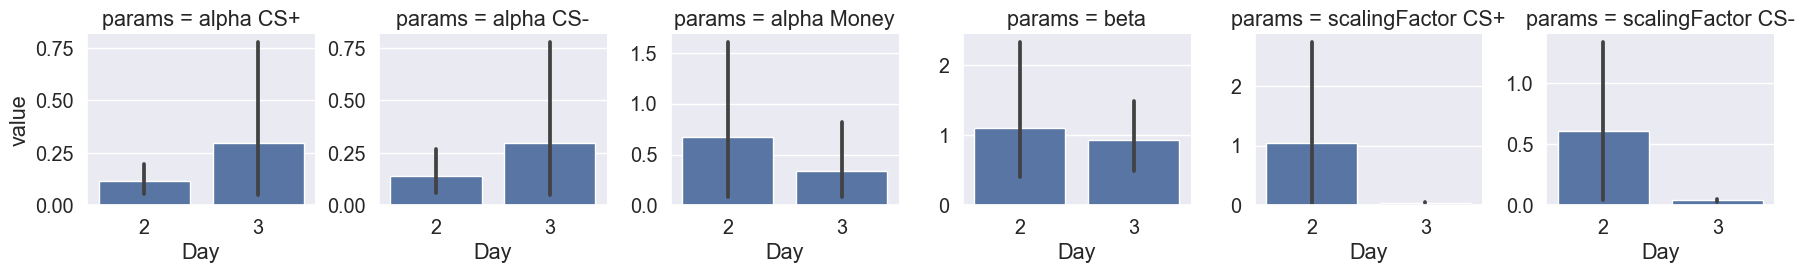

In [27]:
ci_params_longdf = CI_params_df.melt(id_vars = 'Day', var_name='params').reset_index(drop=True)

import numpy as np
ci_params_longdf = ci_params_longdf.replace('', np.nan)
ci_params_longdf.dropna(subset='value', inplace = True)
ci_params_longdf['value'] = ci_params_longdf['value'].astype(float)
ci_params_longdf['Day'] = ci_params_longdf['Day'].astype(object)
ci_params_longdf.dtypes
ci_params_longdf = ci_params_longdf[abs(ci_params_longdf['value'])<10]

g = sns.FacetGrid(ci_params_longdf, col="params", sharey = False)
g.map_dataframe(sns.barplot, x = 'Day', y = 'value')


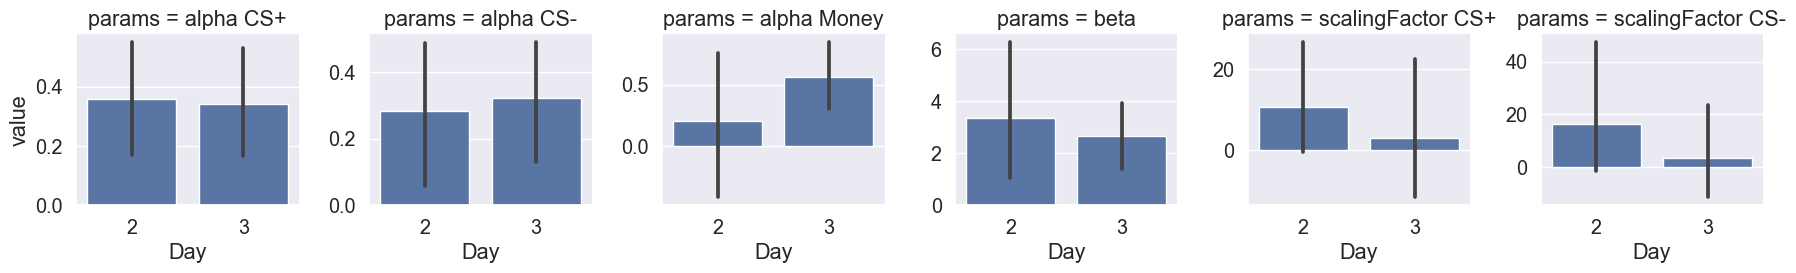

In [28]:
mean_params_longdf = mean_params_df.melt(id_vars = 'Day', var_name='params').reset_index()
import numpy as np
mean_params_longdf = mean_params_longdf.replace('', np.nan)
mean_params_longdf.dropna(subset='value', inplace = True)
mean_params_longdf['value'] = mean_params_longdf['value'].astype(float)
mean_params_longdf.dtypes

# mean_params_longdf = mean_params_longdf[abs(mean_params_longdf['value'])<10]

g = sns.FacetGrid(mean_params_longdf, col="params", sharey = False)
g.map_dataframe(sns.barplot, x = 'Day', y = 'value')
